## Abstract

*Fill in your 3-4 sentence abstract here*

## Research Question

*Fill in your research question here*

# Background and Prior Work

*Fill in your background and prior work here (~500 words). You are welcome to use additional subheadings. You should also include a paragraph describing each dataset and how you'll be using them.* 

### References (include links):
(1)

(2)

## Hypothesis


*Fill in your hypotheses here*

## Setup
*Are there packages that need to be imported, or datasets that need to be downloaded?*

In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from scipy.spatial.distance import pdist, squareform

# Download mouse data in Allen Cell types database

from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.api.queries.cell_types_api import CellTypesApi
import allensdk.brain_observatory.stimulus_info as stim_info
from allensdk.api.queries.rma_api import RmaApi

ctc = CellTypesCache(manifest_file='cell_types/manifest.json')

# Download all the data from mice specificially
mouse_df = pd.DataFrame(ctc.get_cells(species=[CellTypesApi.MOUSE]))

# Download visual response data from Allen Brain Observatory

from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint

boc = BrainObservatoryCache(manifest_file='/datasets/allen-brain-observatory/visual-coding-2p/manifest.json')

# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()

# Import CSV including ISH gene expression data from the two structures

## Approach:

# 1. Did query search on Allen ISH data
# 2. Download as .xml format, then convert it into .csv format through online platform
# 3. Uploaded into the folder as "VISal_VISpm_Converted_No_Threshold.csv" and "VISpm_VISal_Converted_No_Threshold.csv"

# Visual AnteriorLateral Area : Structure.id = 533
# Visual PosteriorMedial Area : Structure.id = 402

# The query search is provided below:
# http://api.brain-map.org/api/v2/data/
# query.xml?criteria=%20service::mouse_differential[set$eq%27mouse_coronal%27][structures1$eq402][structures2$eq533]


VISal_VISpm_pd = pd.read_csv("VISal_VISpm_Converted_No_Threshold.csv")
VISpm_VISal_pd = pd.read_csv("VISpm_VISal_Converted_No_Threshold.csv")


sns.set_palette("bright")

## Data Wrangling

Describe your data wrangling steps here.

In [2]:
# Extract the fold change data and merge the expression data from the two regions

VISal_VISpm_pd_fold = VISal_VISpm_pd[['gene-symbol', 'fold-change']]
VISal_VISpm_length = VISal_VISpm_pd_fold.shape[0]
print("The Lenght of VISal gene expression: " + str(VISal_VISpm_length))
VISal_high = VISal_VISpm_pd_fold[0: int(VISal_VISpm_length * 0.1)]
VISal_low = VISal_VISpm_pd_fold[int(VISal_VISpm_length * 0.9): VISal_VISpm_length]

VISpm_VISal_pd_fold = VISpm_VISal_pd[['gene-symbol', 'fold-change']]
VISpm_VISal_pd_length = VISpm_VISal_pd_fold.shape[0]
print("The Lenght of VISpm gene expression: " + str(VISpm_VISal_pd_length))
VISpm_high = VISpm_VISal_pd_fold[0: int(VISpm_VISal_pd_length * 0.1)]
VISpm_low = VISpm_VISal_pd_fold[int(VISpm_VISal_pd_length * 0.9): VISpm_VISal_pd_length]

The Lenght of VISal gene expression: 2000
The Lenght of VISpm gene expression: 2000


In [3]:
mouse_df = mouse_df.set_index('id')
ephys_features = pd.DataFrame(ctc.get_ephys_features()).set_index('specimen_id')
mouse_ephys_df = mouse_df.join(ephys_features, how ='inner')
ephys_columns = list(ephys_features.columns)

In [4]:
visal_ephys_data = mouse_ephys_df[mouse_ephys_df["structure_area_abbrev"] == "VISal"]
visal_ephys_vrest = visal_ephys_data[['vrest']]
visal_ephys_vrest.columns = ['Vrest']
visal_column = np.repeat("VISal", visal_ephys_vrest.shape[0])
visal_ephys_vrest['Brain Region'] = visal_column


vispm_ephys_data = mouse_ephys_df[mouse_df["structure_area_abbrev"] == "VISpm"]
vispm_ephys_vrest = vispm_ephys_data[['vrest']]
vispm_ephys_vrest.columns = ['Vrest']
vispm_column = np.repeat("VISpm", vispm_ephys_vrest.shape[0])
vispm_ephys_vrest['Brain Region'] = vispm_column

vrest = pd.concat([visal_ephys_vrest, vispm_ephys_vrest])
vrest

al_depth_vs_updownstroke = visal_ephys_data[['fast_trough_v_long_square', 'upstroke_downstroke_ratio_long_square']]
pm_depth_vs_updownstroke = vispm_ephys_data[['fast_trough_v_long_square', 'upstroke_downstroke_ratio_long_square']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [5]:
# Collecting related visual area data from Allen Brain Observatory

print("all targeted structures: " + str(targeted_structures))

visal_data = boc.get_experiment_containers(targeted_structures=['VISal'])
visal_id = visal_data[0]['id']

print("Num of experiments done in VISal: " + str(len(visal_data)))

vispm_data = boc.get_experiment_containers(targeted_structures=['VISpm'])
vispm_id = vispm_data[0]['id']

print("Num of experiments done in VISpm: " + str(len(vispm_data)))

stim = boc.get_all_stimuli()
print("Different Scenes:")
print(stim)

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl']
Num of experiments done in VISal: 41
Num of experiments done in VISpm: 87
Different Scenes:
['drifting_gratings', 'locally_sparse_noise', 'locally_sparse_noise_4deg', 'locally_sparse_noise_8deg', 'natural_movie_one', 'natural_movie_three', 'natural_movie_two', 'natural_scenes', 'spontaneous', 'static_gratings']


In [8]:
# Download cells for a set of experiments and convert to DataFrame
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
print("Total cells: %d" % len(cells))

print("------------------------")
# find direction selective cells in VISal
visal_ec_ids = [ ec['id'] for ec in visal_data ]
visal_cells = cells[cells['experiment_container_id'].isin(visal_ec_ids)]
print("VISal cells: %d" % len(visal_cells))

# Response to drifting gratings stimulus
sig_al_cells = visal_cells[visal_cells['p_dg'] < 0.05]
print("Cells in anteriorlateral visual area with sig. response to drifting gratings: %d" % len(sig_al_cells))

# Direction selective cells
dsi_al_cells = sig_al_cells[(sig_al_cells['g_dsi_dg'] > 0.9)]
print("Anteriorlateral visual area direction-selective cells: %d" % len(dsi_al_cells))

print("------------------------")


# find direction selective cells in VISpm
vispm_ec_ids = [ ec['id'] for ec in vispm_data ]
vispm_cells = cells[cells['experiment_container_id'].isin(vispm_ec_ids)]
print("VISpm cells: %d" % len(vispm_cells))

# Response to drifting gratings stimulus
sig_pm_cells = vispm_cells[vispm_cells['p_dg'] < 0.05]
print("Cells in posteriorlateral visual area with sig. response to drifting gratings: %d" % len(sig_pm_cells))

# Direction selective cells
dsi_pm_cells = sig_pm_cells[(sig_pm_cells['g_dsi_dg'] > 0.9)]
print("Posteriorlateral visual area direction-selective cells: %d" % len(dsi_pm_cells))

Total cells: 63251
------------------------
VISal cells: 7191
Cells in anteriorlateral visual area with sig. response to drifting gratings: 3517
Anteriorlateral visual area direction-selective cells: 169
------------------------
VISpm cells: 7985
Cells in posteriorlateral visual area with sig. response to drifting gratings: 3220
Posteriorlateral visual area direction-selective cells: 171


In [9]:
# find experiment containers for those cells
dsi_al_ids = dsi_al_cells['experiment_container_id'].unique()
print("total al dsi experiment containers: %d" % len(dsi_al_ids))

# Download the ophys experiments containing the drifting gratings stimulus for VISal experiment containers
dsi_al_exps = boc.get_ophys_experiments(experiment_container_ids=dsi_al_ids, stimuli=[stim_info.DRIFTING_GRATINGS])
print("VISal drifting gratings ophys experiments: %d" % len(dsi_al_exps))

total al dsi experiment containers: 30
VISal drifting gratings ophys experiments: 30


In [10]:
from allensdk.brain_observatory.drifting_gratings import DriftingGratings

# example loading drifing grating data
data_set = boc.get_ophys_experiment_data(512326618)
dg = DriftingGratings(data_set)
dg_peak = dg.peak
print("done analyzing drifting gratings")

done analyzing drifting gratings


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# pick a direction-selective cell and find its NWB file
dsi_al_cell = dsi_al_cells.iloc[0]


# figure out which ophys experiment has the drifting gratings stimulus for that cell
cell_exp_1 = boc.get_ophys_experiments(cell_specimen_ids=[dsi_al_cell['cell_specimen_id']],
                                     stimuli=[stim_info.DRIFTING_GRATINGS])[0]

data_set_1 = boc.get_ophys_experiment_data(cell_exp_1['id'])

print("Metadata from NWB file:")
pprint.pprint(data_set_1.get_metadata())

print("stimuli available in this file:")
print(data_set_1.list_stimuli())

dsi_al_cell = dsi_al_cells.iloc[0]

# figure out which ophys experiment has the drifting gratings stimulus for that cell
# cell_exp_2 = boc.get_ophys_experiments(cell_specimen_ids=[dsi_al_cell['cell_specimen_id']],
#                                     stimuli=[stim_info.STATIC_GRATINGS])[0]

# data_set_2 = boc.get_ophys_experiment_data(cell_exp_2['id'])

# print("Metadata from NWB file:")
# pprint.pprint(data_set_2.get_metadata())

Metadata from NWB file:
{'age_days': 88,
 'cre_line': 'Rorb-IRES2-Cre/wt',
 'device': 'Nikon A1R-MP multiphoton microscope',
 'device_name': 'CAM2P.1',
 'excitation_lambda': '910 nanometers',
 'experiment_container_id': 511510794,
 'fov': '400x400 microns (512 x 512 pixels)',
 'genotype': 'Rorb-IRES2-Cre/wt;Camk2a-tTA/wt;Ai93(TITL-GCaMP6f)/wt',
 'imaging_depth_um': 275,
 'indicator': 'GCaMP6f',
 'ophys_experiment_id': 509904120,
 'pipeline_version': '3.0',
 'session_start_time': datetime.datetime(2016, 3, 23, 13, 5, 23),
 'session_type': 'three_session_A',
 'sex': 'male',
 'specimen_name': 'Rorb-IRES2-Cre;Camk2a-tTA;Ai93-231120',
 'targeted_structure': 'VISal'}
stimuli available in this file:
['drifting_gratings', 'natural_movie_one', 'natural_movie_three', 'spontaneous']


In [12]:
# continue filtering data
vis_cells = (dg_peak.ptest_dg < 0.05) &  (dg_peak.peak_dff_dg > 3)

## Data Analysis & Results

Include cells that describe the steps in your data analysis.

Num of gene plotted for VISal: 32
Num of gene plotted for VISpm: 29


Text(0.5, 1.0, 'Gene Expression of VISpm area comparing to VISal area')

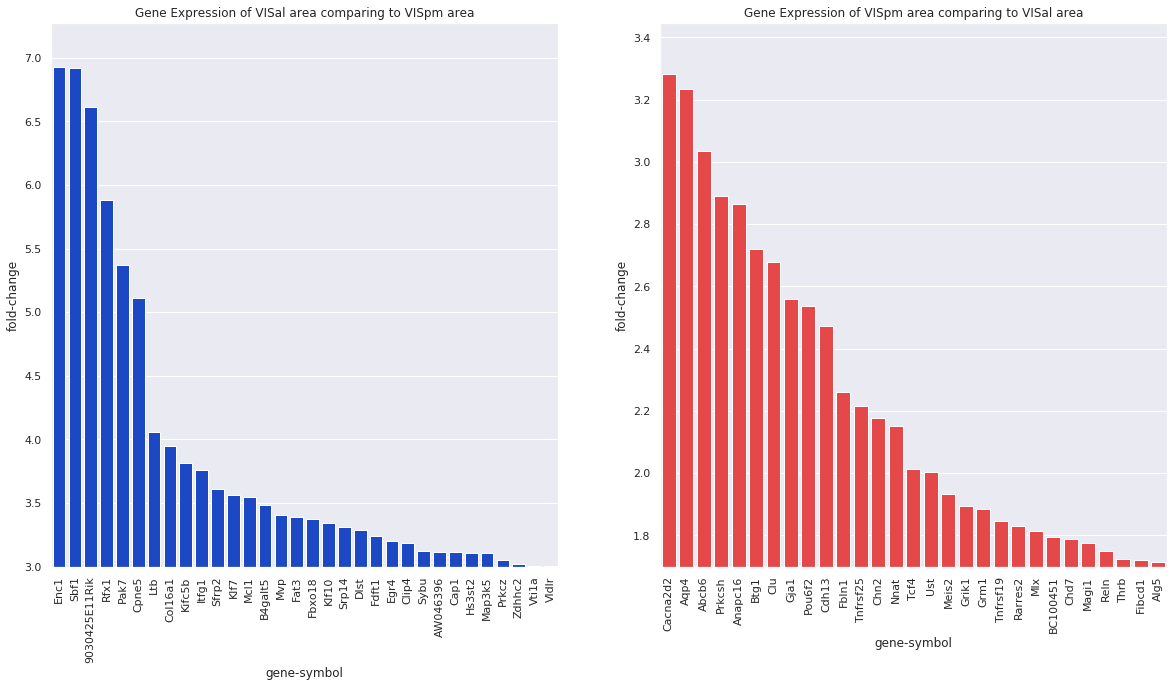

In [13]:
# plotting the gene expression data through barplot
fig, ax = plt.subplots(ncols = 2,figsize=(20,10))
VISal_VISpm_plot= VISal_VISpm_pd_fold[VISal_VISpm_pd_fold["fold-change"] > 3]
VISpm_VISal_plot = VISpm_VISal_pd_fold[VISpm_VISal_pd_fold["fold-change"] > 1.7]

print("Num of gene plotted for VISal: " + str(len(VISal_VISpm_plot)))
print("Num of gene plotted for VISpm: " + str(len(VISpm_VISal_plot)))

ax1 = sns.barplot(x = "gene-symbol", y = "fold-change", data = VISal_VISpm_plot, ax = ax[0], color='#013ADF')
ax1.set_xticklabels(labels = VISal_VISpm_plot['gene-symbol'], rotation=90)
ax1.set_ylim(3,)
ax1.set_title('Gene Expression of VISal area comparing to VISpm area')

custom_palette = sns.color_palette("RdGy", 2)
ax2 = sns.barplot(x = "gene-symbol", y = "fold-change", data = VISpm_VISal_plot, ax = ax[1], color='#FE2E2E' )
ax2.set_xticklabels(labels = VISpm_VISal_plot['gene-symbol'], rotation=90)
ax2.set_ylim(1.7,)
ax2.set_title('Gene Expression of VISpm area comparing to VISal area')

In [14]:
# Plotting comparative data of gene expression from area VISal and VISpm

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0, 0.5, 'Membrane Potential')

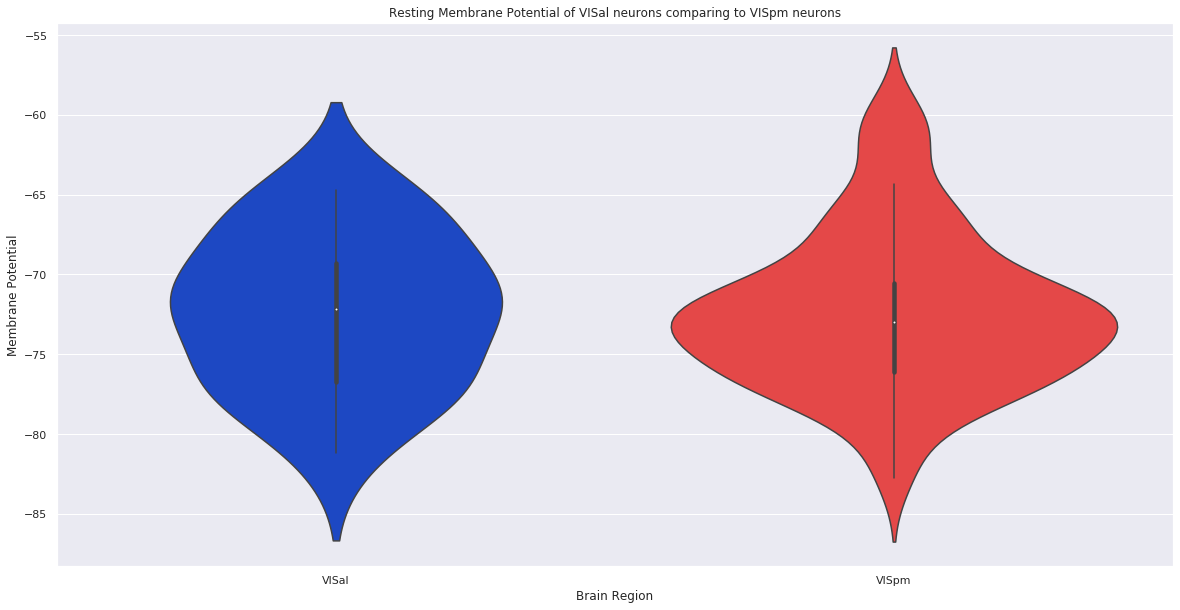

In [15]:
# Plotting electrophysiological data for the two areas with box plot/ Violin plot:
# Resting potential
fig, ax1 = plt.subplots(ncols = 1, figsize=(20,10))
custom = ["#013ADF","#FE2E2E"]

sns.violinplot(y = 'Vrest', x = 'Brain Region', data = vrest, ax = ax1, palette = custom, orient = 'v')
ax1.set_title('Resting Membrane Potential of VISal neurons comparing to VISpm neurons')
ax1.set_ylabel('Membrane Potential')

Text(0, 0.5, 'upstroke-downstroke ratio')

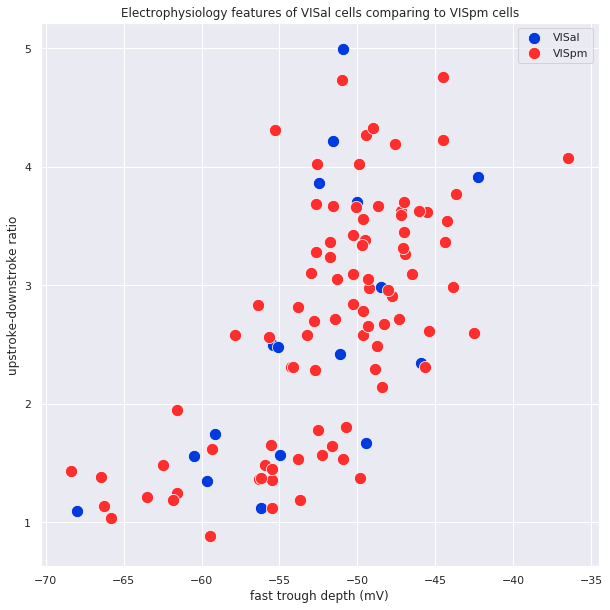

In [16]:
# plotting Scatterplot that compares upstroke downstroke ratio with fast trough depth
fig, ax = plt.subplots(ncols = 1,figsize=(10,10))

ax3 = sns.scatterplot(x = al_depth_vs_updownstroke['fast_trough_v_long_square'], 
            y = al_depth_vs_updownstroke['upstroke_downstroke_ratio_long_square'], 
                data = al_depth_vs_updownstroke,
                ax = ax,
                color='#013ADF',
                     s = 150)

ax3.set_title('Electrophysiology features of VISal cells comparing to VISpm cells')


ax4 = sns.scatterplot(x = pm_depth_vs_updownstroke['fast_trough_v_long_square'], 
            y = pm_depth_vs_updownstroke['upstroke_downstroke_ratio_long_square'], 
                data = pm_depth_vs_updownstroke,
                ax = ax,
                color='#FE2E2E',
                     s = 150)

ax3.legend(labels = ['VISal', 'VISpm'])
ax3.set_xlabel("fast trough depth (mV)")
ax3.set_ylabel("upstroke-downstroke ratio")

In [17]:
# find direction selective cells in VISal
visal_ec_ids = [ ec['id'] for ec in visal_data ]
visal_cells = cells[cells['experiment_container_id'].isin(visal_ec_ids)]
print("VISal cells: %d" % len(visal_cells))

# Response to drifting gratings stimulus
sig_al_cells = visal_cells[visal_cells['p_dg'] < 0.05]
print("Cells in anteriorlateral visual area with sig. response to drifting gratings: %d" % len(sig_al_cells))

# Direction selective cells
dsi_al_cells = sig_al_cells[(sig_al_cells['g_dsi_dg'] > 0.9)]
print("Anteriorlateral visual area direction-selective cells: %d" % len(dsi_al_cells))

print("------------------------")


# find direction selective cells in VISpm
vispm_ec_ids = [ ec['id'] for ec in vispm_data ]
vispm_cells = cells[cells['experiment_container_id'].isin(vispm_ec_ids)]
print("VISpm cells: %d" % len(vispm_cells))

# Response to drifting gratings stimulus
sig_pm_cells = vispm_cells[vispm_cells['p_dg'] < 0.05]
print("Cells in posteriorlateral visual area with sig. response to drifting gratings: %d" % len(sig_pm_cells))

# Direction selective cells
dsi_pm_cells = sig_pm_cells[(sig_pm_cells['g_dsi_dg'] > 0.9)]
print("Posteriorlateral visual area direction-selective cells: %d" % len(dsi_pm_cells))

VISal cells: 7191
Cells in anteriorlateral visual area with sig. response to drifting gratings: 3517
Anteriorlateral visual area direction-selective cells: 169
------------------------
VISpm cells: 7985
Cells in posteriorlateral visual area with sig. response to drifting gratings: 3220
Posteriorlateral visual area direction-selective cells: 171


## Conclusion & Discussion

*Fill in your discussion information here*